In [1]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tensorflow.keras.backend import backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Reshape, Flatten, Conv1D
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.utils import to_categorical

In [2]:
datos = pd.read_csv("./data/all_counts_9_norm_rpkm.csv", index_col=0, usecols=["gene", "BB9", "BB10", "BB17",
                                                                              "BB19", "BB20", "BB21",
                                                                              "BB11", "BB12", "BB18"])
print("Tamanho dos dados:", datos.shape)
datos = np.log2(datos + 1)
datos.head()

Tamanho dos dados: (4293, 9)


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,5.542667,5.876225,5.189101,6.178741,6.258982,5.921482,6.565341,6.308676,6.256590
aaeB,5.627977,5.436188,5.397088,5.493631,5.603751,5.716862,5.840627,6.132819,5.896502
aaeR,5.645506,5.758852,5.107190,5.824890,5.487705,6.033795,5.710782,6.302440,16.270368
aaeX,6.081770,6.043589,6.030808,6.358792,15.682419,6.129392,6.042647,6.134309,15.797839
aas,6.224669,6.297153,6.297008,6.047021,6.038410,6.296795,6.295251,6.598525,6.568365


In [3]:
rg = open("./data/reference_genes.txt", "r", newline="\n")
hkg = [i for i in rg.read().splitlines()]
print("Quantidade de genes housekeeping:", len(hkg))
print(hkg)

Quantidade de genes housekeeping: 21
['cysG', 'hcaT', 'idnT', 'rrsA', 'ihfB', 'ssrA', 'gyrA', 'recA', 'rpoB', 'rpoA', 'gyrB', 'rho', 'ftsZ', 'secA', 'rpoC', 'gmk', 'adk', 'rpoD', 'dnaG', 'glnA', 'recF']


In [4]:
#X_train = X_train.sample(n=100)
X_train = datos.loc[hkg].dropna()
X_train.shape

(21, 9)

In [5]:
max_val = 1
min_val = -1
min_train = np.min(X_train)
max_train = np.max(X_train)
X_train = ((X_train - min_train)/(max_train - min_train))*(max_val - min_val) + min_val
X_train

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,-0.969147,-0.978963,-0.973373,-1.000000,-0.999813,-0.970143,-0.970659,-0.911181,-0.890876
hcaT,-1.000000,-1.000000,-1.000000,-0.972570,-0.959389,-1.000000,-1.000000,-1.000000,-1.000000
idnT,-0.946080,-0.948025,-0.944276,-0.914840,-1.000000,-0.930703,-0.942743,0.562604,0.575625
rrsA,-0.296977,-0.271812,-0.168266,-0.122535,-0.154926,-0.254901,-0.359582,-0.594943,-0.310966
ihfB,-0.132088,-0.126050,-0.000049,0.064988,0.044301,-0.020681,-0.124403,-0.385905,-0.208607
ssrA,0.052847,0.053385,0.163319,0.308490,0.266177,0.174393,0.219843,-0.010831,0.155377
gyrA,1.000000,0.994874,-0.356674,1.000000,1.000000,0.909390,0.725292,0.567331,0.731382
recA,0.616219,0.599711,0.632131,-0.209725,-0.265186,-0.370792,1.000000,0.783242,1.000000
rpoB,-0.519856,0.926579,-0.380312,0.992837,0.985678,0.886011,-0.662111,0.593895,0.772322


In [6]:
datos = ((datos - min_train)/(max_train - min_train))*(max_val - min_val) + min_val
datos

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,-1.021960,-0.979435,-1.070980,-0.936075,-0.964066,-1.031994,-0.934337,-0.939543,-0.937269
aaeB,-1.009480,-1.042995,-1.041304,-1.034891,-1.060696,-1.063096,-1.039629,-0.965042,-0.989310
aaeR,-1.006916,-0.996388,-1.082667,-0.987112,-1.077810,-1.014922,-1.058494,-0.940447,0.509951
aaeX,-0.943096,-0.955260,-0.950883,-0.910106,0.425654,-1.000392,-1.010278,-0.964826,0.441659
aas,-0.922192,-0.918634,-0.912901,-0.955073,-0.996595,-0.974946,-0.973578,-0.897515,-0.892211
...,...,...,...,...,...,...,...,...,...
zraR,-1.073748,-1.153982,-1.150891,-1.137953,-1.132580,-1.105349,-1.116639,-1.037092,-1.073255
zraS,-1.031483,-1.113467,-1.079660,-1.046629,-1.133967,-1.096935,0.425981,-1.018809,-1.047886
zupT,-0.722573,0.721750,0.753271,0.759741,0.757678,0.733104,0.654379,0.607526,0.687909


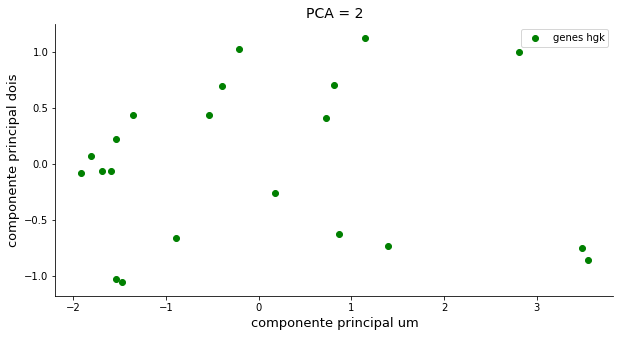

In [7]:
pca_real = PCA(n_components=2)
X_train_pca = pca_real.fit_transform(X_train)
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title("PCA = 2", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="genes hgk")
plt.legend();

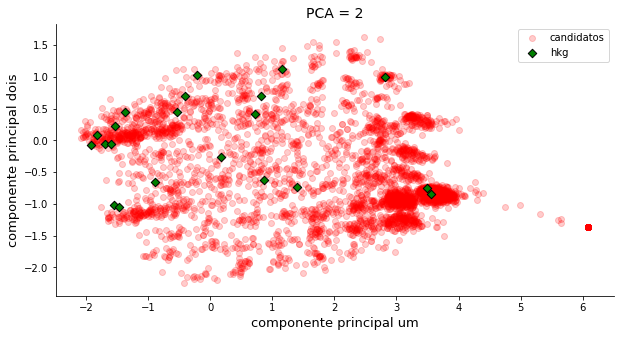

In [8]:
pca_real = PCA(n_components=2)
X_train_pca = pca_real.fit_transform(X_train)
datos_pca = pca_real.transform(datos)
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title("PCA = 2", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(datos_pca[:,0], datos_pca[:,1], alpha=.2, color="red", label="candidatos")
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], edgecolors="black", color="green", label="hkg",
           marker="D")
plt.legend();

In [9]:
class Generator():
    def __init__(self, noise_input, out_dim, optimizerG):
        self.noise_input = noise_input
        self.out_dim = out_dim
        self.optimizerG = optimizerG
        
    def generator(self):
        """
        noise_input: vector con los datos de la distribuición inicial
        out_dim: dimension de la salida esperada, por ejemplo si es una imagen
                 en escala de gris, sería out_dim: (32,32,1)
        Retorna el modelo Generador
        """
        model = Sequential()
        model.add(Dense(50, input_shape=(self.noise_input,)))
        model.add(Dense(150))
        model.add(Dropout(.1))
        model.add(Dense(np.prod(self.out_dim), activation="tanh"))
        model.add(Reshape(self.out_dim))
        return model
    
    def compileG(self):
        Gr = self.generator()
        Gr.compile(loss="binary_crossentropy", optimizer= self.optimizerG)
        return Gr

In [10]:
class Discriminator():
    
    def __init__(self, input_dim, optimizerD):
        self.input_dim = input_dim
        self.optimizerD = optimizerD
    
    def discriminator(self):
        """
        input_dim: dimension de los datos de entrada,
                   por ejemplo si es una imagen en escala de gris,
                   sería input_dim: (32,32,1)
        """
        model = Sequential()
        model.add(Dense(32, input_shape=self.input_dim))
        model.add(LeakyReLU(alpha=.2)) #función rectificadora
        model.add(Dense(32))
        #model.add(LeakyReLU(alpha=.1)) #función rectificadora
        #activación sigmoid ya que se precisa establecer si es 0 ó 1.
        model.add(Dense(1, activation='sigmoid'))
        return model
    
    def compileD(self):
        Dr = self.discriminator()
        Dr.compile(loss="binary_crossentropy", optimizer=optimizerD, metrics=["accuracy"])
        return Dr

In [11]:
def Gan(generator, discriminator):
    """
    recibe como parámetros de entrada las redes
    generador y discriminador
    """
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False #no se actualizan los pesos
    model.add(discriminator)
    return model

In [12]:
noise_input = 32
#Gerador
#optimizerG = Adam(lr=0.0001, beta_1=0.4)
optimizerG = SGD(lr=0.00015, momentum=0.92, decay=0.00015/1500)
obj_G = Generator(noise_input, (X_train.shape[1],), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()
# Discriminador
#optimizerD = Adam(lr=0.002, beta_1=0.9)
optimizerD = SGD(lr=0.01, momentum=0.9, decay=0.01/1500)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()

gan = Gan(G,D)
gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
gan.summary()

Dimension del ruido de entrada:  32
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 9)                 10659     
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1409      
Total params: 12,068
Trainable params: 10,659
Non-trainable params: 1,409
_________________________________________________________________


In [13]:
def KLD(p_g):
    """artigo: GANs and Divergence Minimization"""
    return np.mean(np.log(p_g))

In [14]:
dist_z = np.random.normal(size=(X_train.shape))
X_predict = np.concatenate((X_train, dist_z))
p_d = np.ravel(D.predict(X_predict))
print("KLD: ", KLD(p_d))

KLD:  -0.67218983


(21, 2) (800, 2)


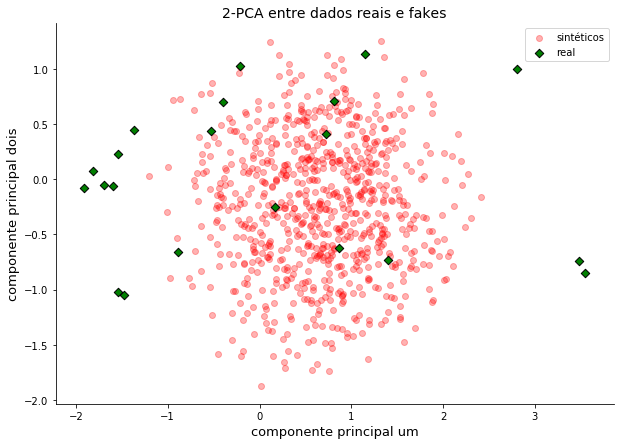

In [15]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
x_noise = G.predict(np.random.normal(loc=0, scale=1, size=(800,noise_input)))
X_fake_pca = pca_real.transform(x_noise)
print(X_train_pca.shape, X_fake_pca.shape)
plt.title("2-PCA entre dados reais e fakes", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_fake_pca[:,0], X_fake_pca[:,1], color="red", label="sintéticos", alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], edgecolor="black", color="green", label="real", alpha=1,
           marker="D")
plt.legend();

In [16]:
def get_batches(X_train, batch_size):
    """
    X_train: dataset para o treino
    epochs: quantidade de epocas para o treino do gradiente
    batch: tamanho to batch pra o treino de cada epochs
    """
    batches = []
    num_bat = int(np.ceil(X_train.shape[0]/batch_size))
    lim_i = 0
    lim_s = batch_size
    for i in range(num_bat):
        if lim_s > X_train.shape[0]:
            lim_s = X_train.shape[0]
        batches.append(X_train[lim_i:lim_s])
        lim_i += batch_size
        lim_s += batch_size
    return batches

In [56]:
#treinamento da GAN
def train(X_train, epochs, batch_size, G, D, gan, noise_input):
    g_loss = []
    d_loss = []
    g_lr = []
    for epoch in range(epochs):
        batches = get_batches(X_train, batch_size)
        count_b = 0
        t_i = time()
        d_bacth_loss = []
        g_bacth_loss = []
        g_lr.append(G.optimizer.get_config()["learning_rate"])
        for batch in batches:
            gen_noise = np.random.normal(0, 1, (np.int64(batch.shape[0]), noise_input))
            #gerando as imagens fake
            syntetic_data = G.predict(gen_noise)
            #criação do array de treinamento
            x_combined_batch = np.concatenate((batch, syntetic_data))
            y_combined_batch = np.concatenate((np.ones((batch.shape[0], 1)),
                                               np.zeros((batch.shape[0], 1))))
            #misturar os dados
            #x_combined_batch, y_combined_batch = shuffle(x_combined_batch, y_combined_batch)
            #treino do discriminadorss
            for i in range(2):
                r = D.train_on_batch(x_combined_batch, y_combined_batch)[0]
            d_bacth_loss.append(D.train_on_batch(x_combined_batch, y_combined_batch)[0])
            # train generator
            noise = np.random.normal(0, 1, (batch.shape[0], noise_input))
            y_mislabled = np.ones((batch.shape[0], 1))
            g_bacth_loss.append(gan.train_on_batch(noise, y_mislabled))
            #print(g_bacth_loss)
            
        t_f = time()
        t = t_f - t_i
        t_i = time()
        #d_loss.append(np.mean(np.array(d_bacth_loss)))
        #g_loss.append(np.mean(np.array(g_bacth_loss)))
        d_loss.append(d_bacth_loss[-1])
        g_loss.append(g_bacth_loss[-1])
        if epoch%100 == 0:
            print ('epoch:[%d/%d] [Discriminator::d_loss: %f],[Generator::loss: %f], %f[sec]'
                   % (epoch+1, epochs, d_loss[-1], g_loss[-1], t))
    return g_loss, d_loss, g_lr


In [57]:
gan.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_12 (Sequential)   (None, 9)                 11559     
_________________________________________________________________
sequential_13 (Sequential)   (None, 1)                 1409      
Total params: 12,968
Trainable params: 11,559
Non-trainable params: 1,409
_________________________________________________________________


In [58]:
noise_input = 50
ep = 1700
#Gerador
optimizerG = SGD(lr=0.00015, momentum=0.92, decay=0.00015/ep)
#optimizerG = SGD(lr=0.00011, momentum=0.92)
obj_G = Generator(noise_input, (X_train.shape[1],), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()
# Discriminador
optimizerD = SGD(lr=0.001, momentum=0.9, decay=0.001/ep)
#optimizerD = SGD(lr=0.001, momentum=0.9)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()
gan = Gan(G,D)
gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
gan.summary()

Dimension del ruido de entrada:  50
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_15 (Sequential)   (None, 9)                 11559     
_________________________________________________________________
sequential_16 (Sequential)   (None, 1)                 1409      
Total params: 12,968
Trainable params: 11,559
Non-trainable params: 1,409
_________________________________________________________________


In [59]:
g_loss, d_loss, lr = train(X_train, epochs=ep, batch_size=X_train.shape[0], G=G, D=D, gan=gan,
                       noise_input=noise_input)

epoch:[1/1700] [Discriminator::d_loss: 0.718374],[Generator::loss: 0.691366], 0.604513[sec]
epoch:[101/1700] [Discriminator::d_loss: 0.622312],[Generator::loss: 0.846151], 0.030900[sec]
epoch:[201/1700] [Discriminator::d_loss: 0.537089],[Generator::loss: 0.903427], 0.029191[sec]
epoch:[301/1700] [Discriminator::d_loss: 0.505004],[Generator::loss: 0.994450], 0.029649[sec]
epoch:[401/1700] [Discriminator::d_loss: 0.619849],[Generator::loss: 1.063442], 0.029646[sec]
epoch:[501/1700] [Discriminator::d_loss: 0.681604],[Generator::loss: 1.017193], 0.029555[sec]
epoch:[601/1700] [Discriminator::d_loss: 0.687853],[Generator::loss: 0.818894], 0.029324[sec]
epoch:[701/1700] [Discriminator::d_loss: 0.677231],[Generator::loss: 0.920131], 0.029268[sec]
epoch:[801/1700] [Discriminator::d_loss: 0.680600],[Generator::loss: 0.767332], 0.029773[sec]
epoch:[901/1700] [Discriminator::d_loss: 0.653693],[Generator::loss: 0.782813], 0.029276[sec]
epoch:[1001/1700] [Discriminator::d_loss: 0.643016],[Generator

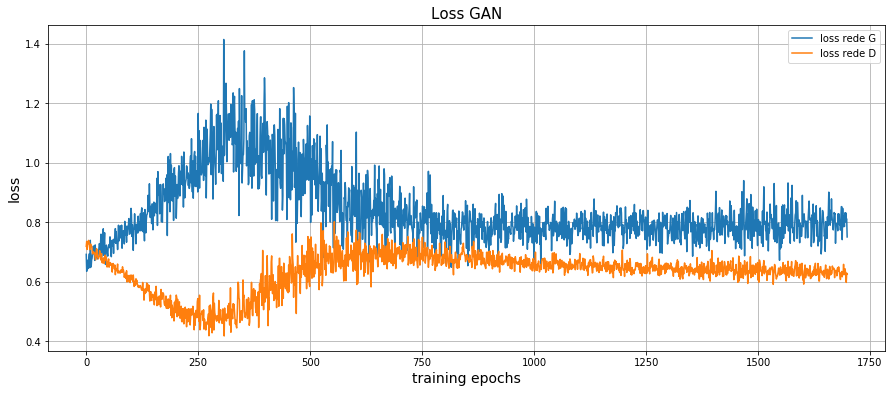

In [60]:
plt.figure(figsize=(15,6))
plt.title("Loss GAN", fontsize=15)
plt.plot(range(ep), g_loss, label="loss rede G")
plt.plot(range(ep), d_loss, label="loss rede D")
plt.xlabel("training epochs", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.grid()
plt.legend();

### Kullback-Leiber Divergence
$$D_{KL}(P\|Q) = \sum_{x}P(x)\log_{2}\left(\frac{P(x)}{Q(x)}\right)$$

(21, 2) (500, 2)


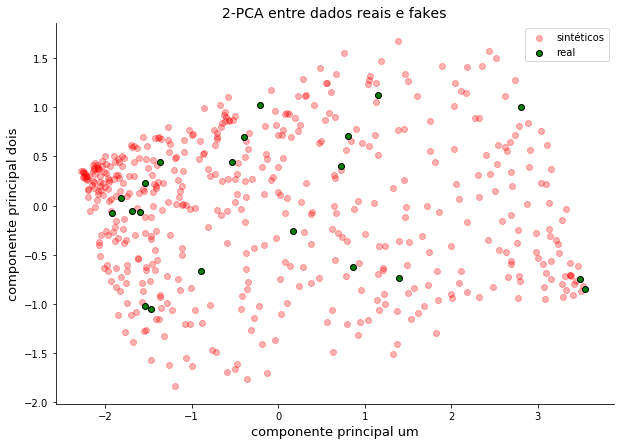

In [61]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
x_noise = G.predict(np.random.normal(loc=0, scale=1, size=(500,noise_input)))
X_fake_pca = pca_real.transform(x_noise)
print(X_train_pca.shape, X_fake_pca.shape)
plt.title("2-PCA entre dados reais e fakes", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_fake_pca[:,0], X_fake_pca[:,1], color="red", label="sintéticos", alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], edgecolor="black", color="green", label="real", alpha=1)
plt.legend();

In [46]:
def KLD(p):
    return np.sum((1-p)*np.log((1-p)/p))

In [47]:
synthetics = G.predict(np.random.normal(loc=0, scale=1, size=(2000,noise_input)))
p = D.predict_proba(synthetics)

In [48]:
KLD(p)

889.5071

In [91]:
p = np.array([0.55,.4,.05])

In [94]:
from scipy.special import rel_entr

sum(rel_entr(p, p-1))

inf

In [108]:
p = np.array([0.1,.2,.3,0.4])
q = np.array([0.15,.15,.35,0.35])

sum(rel_entr(p, q))

0.02415725678117142

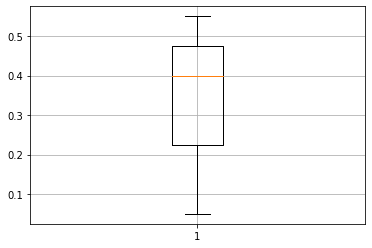

In [93]:
plt.grid()
plt.boxplot(p);